In [307]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [308]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [309]:

# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(Xtr.shape, Ytr.shape)

torch.Size([182625, 4]) torch.Size([182625])


In [371]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C1 = torch.randn((27, 40), generator=g)
C2 = torch.randn((27, 40), generator=g)
W1 = torch.randn((160, 200), generator=g, requires_grad=True)

W1_combined = torch.randn((200, 200), generator=g) * .01
b1 = torch.randn(200, generator=g) * .01
W2 = torch.randn((200, 27), generator=g) * .01
b2 = torch.randn(27, generator=g) * 0
parameters = [C1, W1, b1, W2, b2, W1_combined]
sum(p.nelement() for p in parameters) # number of parameters in total

78707

In [372]:
for p in parameters:
  p.requires_grad = True

In [373]:
lri = []
lossi = []
stepi = []

In [396]:
# Updated Training Loop with Energy Minimization
for i in range(10000):
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    emb1 = C1[Xtr[ix]]  # (32, 3, 10)

    # Compute hidden states
    h1 = torch.tanh(emb1.view(32, -1) @ W1 + b1)  # (32, 200)
    logits = h1 @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # Predict classes and compute additional embedding
    pred_classes = torch.argmax(logits, dim=1)
    emb2 = C2[pred_classes]  # (32, 10)

    # Concatenate embeddings and compute combined hidden state
    combined_emb = torch.cat([emb1.view(32, -1), emb2], dim=1)  # (32, 40)
    hpreact = combined_emb @ W1_combined + b1
    h_combined = torch.tanh(hpreact)  # (32, 200)

    seq_bias_sum = b1[Xtr[ix]].sum(dim=1, keepdim=True)  # (32,)

    # Full energy computation
    energy_scores = torch.tanh(h_combined @ W2 + b2) + seq_bias_sum
    energy_loss = F.cross_entropy(-energy_scores, Ytr[ix])
    probs = torch.softmax(-energy_scores, dim=1)


    total_loss = loss + energy_loss  

    # Backward pass
    for p in parameters:
        p.grad = None 
    total_loss.backward()

    # Update parameters
    lr = 0.01 if i < 100000 else 0.001  
    for p in parameters:
        p.data -= lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(total_loss.log10().item())



torch.Size([32, 200])


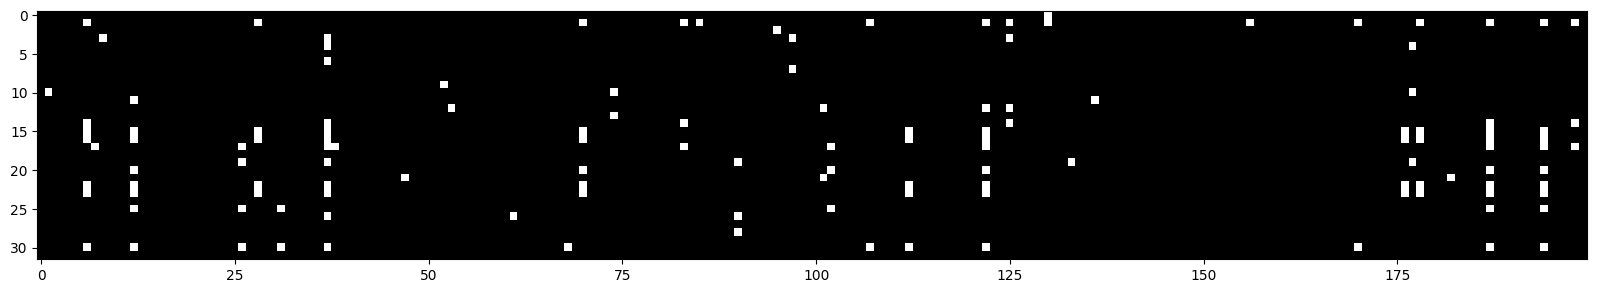

In [397]:
plt.figure(figsize=(20,10))
plt.imshow(h_combined.abs() > .99, cmap='gray', interpolation='nearest')
print(h_combined.shape)

(array([273., 251., 221., 156., 143., 161., 157., 152., 124., 148., 130.,
        110., 126., 114., 114.,  95., 119., 109., 114.,  91.,  83.,  97.,
        104.,  80.,  86., 105.,  85.,  74.,  83.,  95., 103.,  95., 103.,
        105., 103., 113.,  76.,  89., 108., 109., 104., 123., 135., 153.,
        160., 146., 162., 176., 217., 220.]),
 array([-9.99534726e-01, -9.59557620e-01, -9.19580514e-01, -8.79603409e-01,
        -8.39626303e-01, -7.99649197e-01, -7.59672091e-01, -7.19694985e-01,
        -6.79717879e-01, -6.39740773e-01, -5.99763668e-01, -5.59786562e-01,
        -5.19809456e-01, -4.79832350e-01, -4.39855244e-01, -3.99878138e-01,
        -3.59901032e-01, -3.19923927e-01, -2.79946821e-01, -2.39969715e-01,
        -1.99992609e-01, -1.60015503e-01, -1.20038397e-01, -8.00612915e-02,
        -4.00841856e-02, -1.07079744e-04,  3.98700261e-02,  7.98471320e-02,
         1.19824238e-01,  1.59801344e-01,  1.99778450e-01,  2.39755555e-01,
         2.79732661e-01,  3.19709767e-01,  3.59686

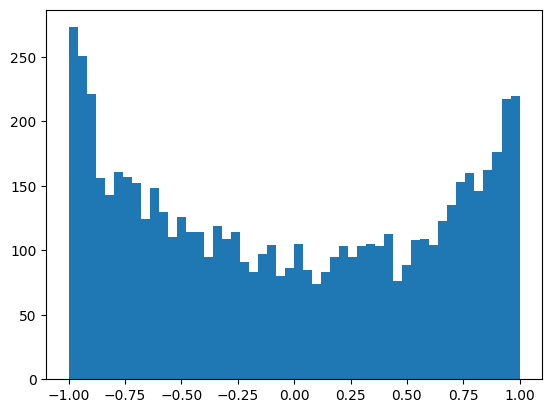

In [398]:
plt.hist(h_combined.view(-1).tolist(), 50)

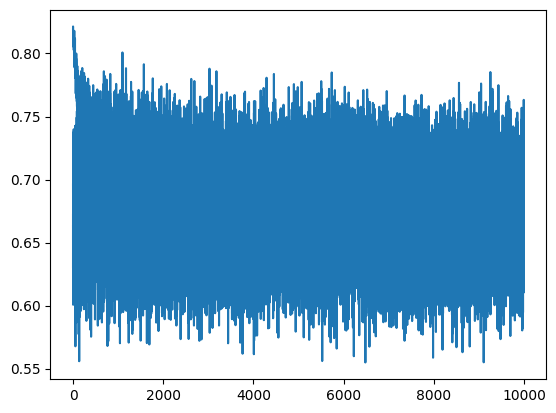

In [399]:
plt.plot(stepi, lossi)

In [394]:
import torch
import torch.nn.functional as F

emb1 = C1[Xtr] 

h1 = torch.tanh(emb1.view(emb1.shape[0], -1) @ W1 + b1)  

# Compute logits for classification
logits = h1 @ W2 + b2  

# Compute the cross-entropy loss
loss = F.cross_entropy(logits, Ytr) 
print(f"Loss: {loss.item()}")


Loss: 2.215470314025879


In [385]:
import torch
import torch.nn.functional as F


emb1 = C1[Xdev]  


h1 = torch.tanh(emb1.view(emb1.shape[0], -1) @ W1 + b1) 


logits = h1 @ W2 + b2  


loss = F.cross_entropy(logits, Ydev) 
print(f"Loss: {loss.item()}")


Loss: 2.2740869522094727


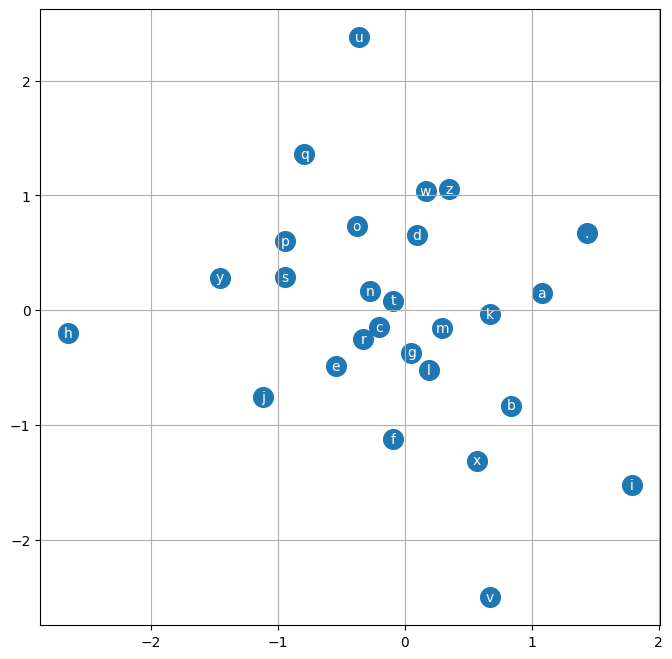

In [400]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C2[:,0].data, C2[:,1].data, s=200)
for i in range(C2.shape[0]):
    plt.text(C2[i,0].item(), C2[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [401]:
import torch
import torch.nn.functional as F


emb1 = C1[Xte]  


h1 = torch.tanh(emb1.view(emb1.shape[0], -1) @ W1 + b1) 

logits = h1 @ W2 + b2

loss = F.cross_entropy(logits, Yte)  
print(f"Loss: {loss.item()}")


Loss: 2.224665403366089


In [402]:
import torch
import torch.nn.functional as F

# Initialize generator with a fixed seed
g = torch.Generator().manual_seed(2147483640)

for _ in range(20):  # Generate 20 sequences
    
    out = []
    context = [0] * block_size  # Initialize context with padding (or special start tokens)
    
    while True:
        # Embedding lookups for input context
        emb1 = C1[torch.tensor([context])]  # Shape: (1, block_size, d1)
        h1 = torch.tanh(emb1.view(1, -1) @ W1 + b1)  # Hidden layer: Shape (1, hidden_dim)
        
        # Compute logits for current context
        logits = h1 @ W2 + b2  # Shape: (1, vocab_size)
        probs = F.softmax(logits, dim=1)  # Compute probabilities over vocabulary
        
        # Sample the next token
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()  # Random sampling
        context = context[1:] + [ix]  # Update context with the new token
        out.append(ix)  # Add token to output sequence
        
        # Stop if end-of-sequence token (assume 0 is the EOS token)
        if ix == 0:
            break
    
    # Decode output sequence using `itos` (index-to-string mapping)
    print(''.join(itos[i] for i in out))


dess.
jusabu.
leigh.
joyannare.
emmiyatsi.
nala.
jaingen.
oweas.
jiylon.
jhanno.
jorde.
oluwi.
aita.
joor.
palaya.
romios.
p.
cyron.
tina.
raie.
